##Import e style

In [1]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
#####

RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()#Rende visibili le modifiche

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda')

## Importa dataser



In [2]:
!rm -rf GTSRB
!rm -rf data
!rm -rd GTSRB_Final_Training_Images.zip

rm: cannot remove 'GTSRB_Final_Training_Images.zip': No such file or directory


In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-11 20:48:46--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  24.7MB/s    in 12s     

2022-07-11 20:48:58 (22.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration 


In [4]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
print("Classi:")
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [5]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_image2(img_path):
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'size: {img.size}')
    ax[0].imshow(img)

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


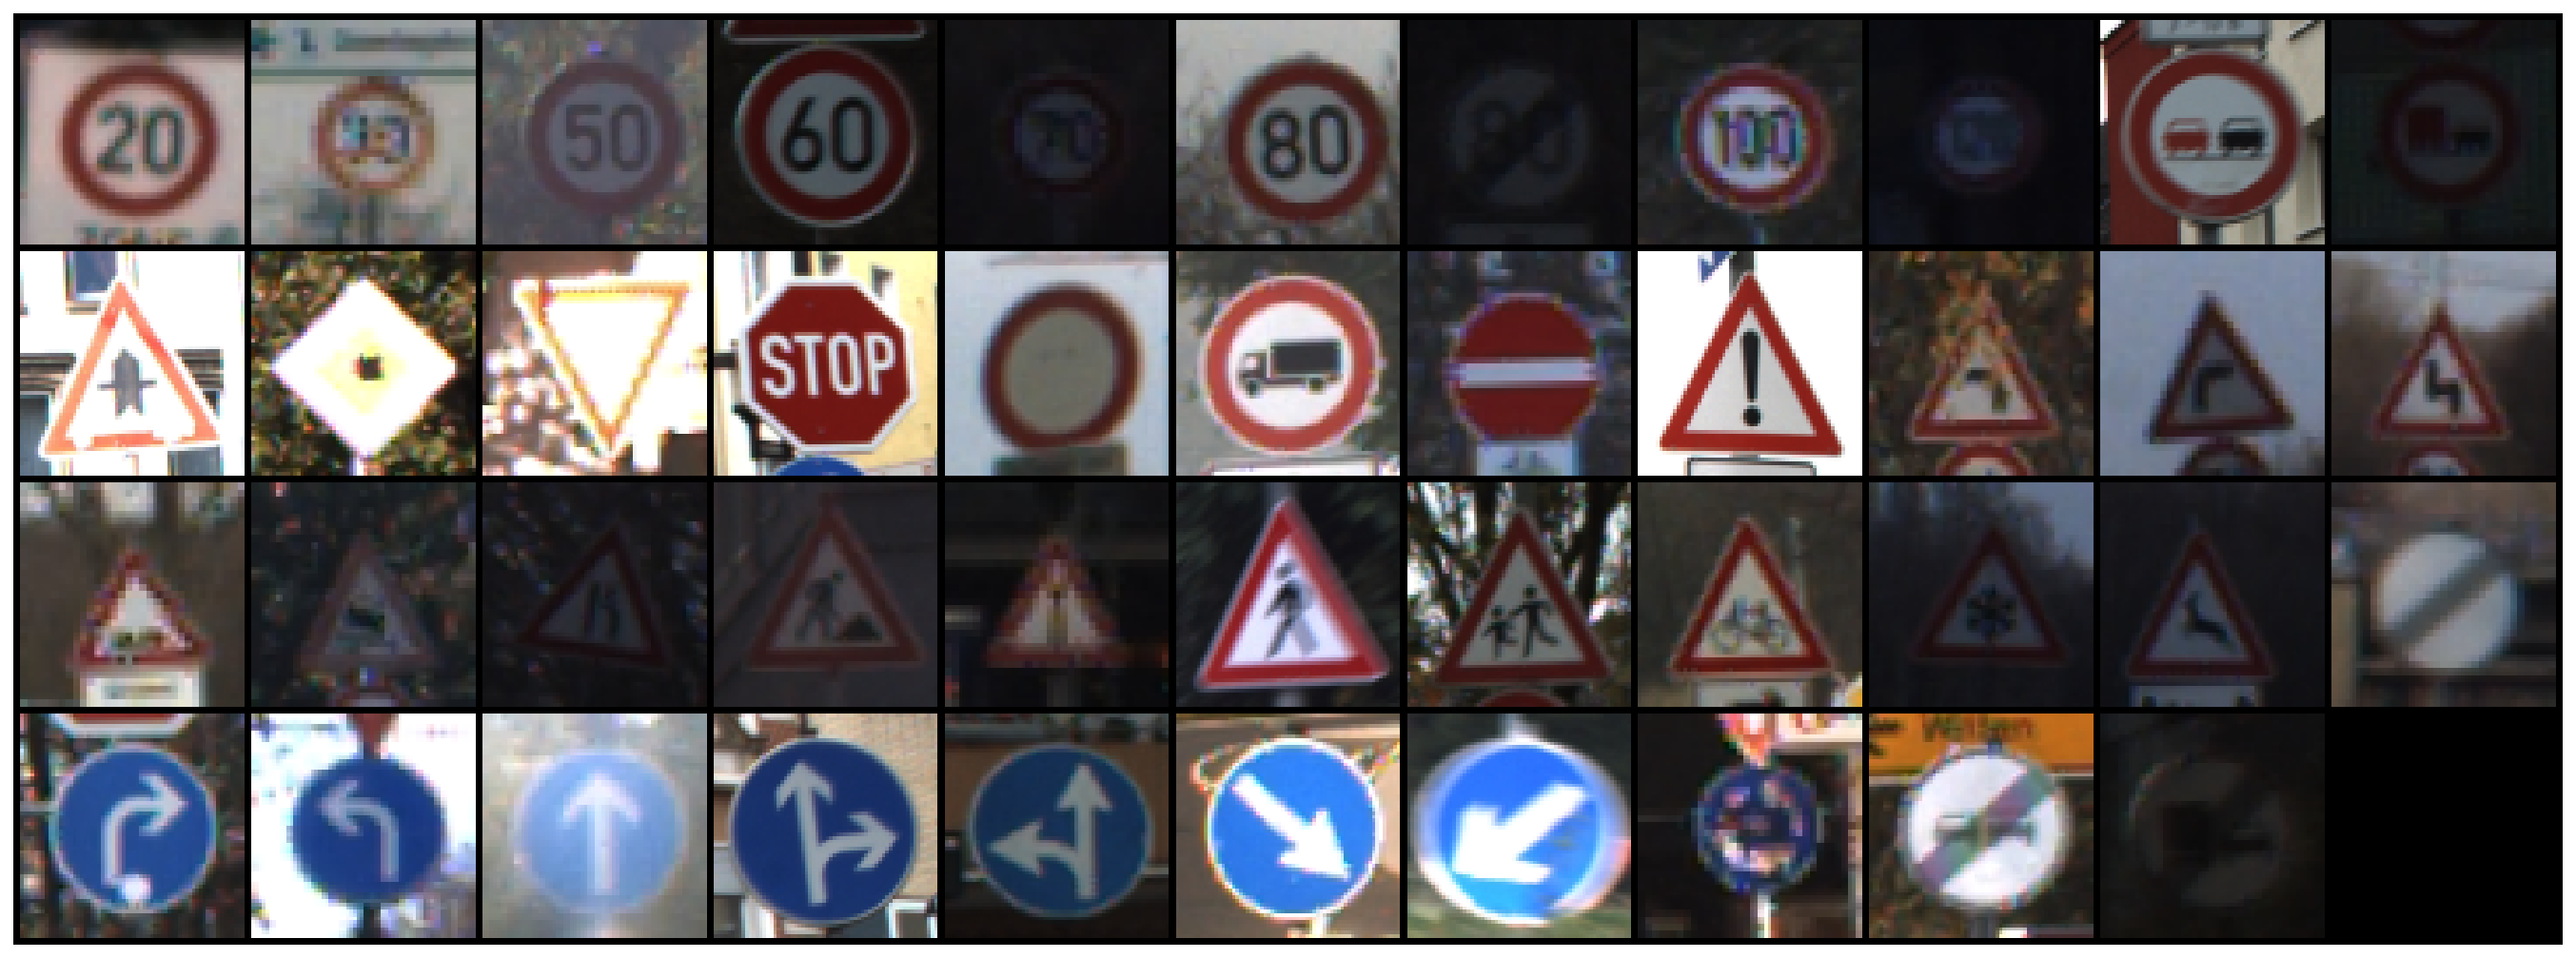

In [6]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

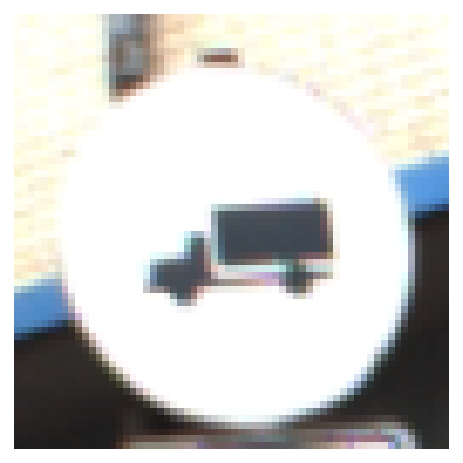

In [7]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [8]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]
'''

class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [9]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**80% training, 10% validation, 10% test per ogni classe** (Nella corrispettiva cartella)

In [10]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing for vehicles over 3.5 metric tons: 2010
Right-of-way at the next intersection: 1320
Priority road: 2100
Yield (give_way): 2160
Stop: 780
No vehicles: 630
Vehicles over 3.5 metric tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve to the left: 210
Dangerous curve to the right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End of all speed and passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [11]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomAffine(degrees=(-20, 20), translate=(0.1,0.3), scale=(0.6,1), shear=(-20, 20)),
  #T.RandomErasing(), #cancella autonomamente parti dell'immagine
  #AddGaussianNoise(0.1, 0.08),  #rumore gaussiano (vero e proprio "rumore del sensore", disturbo)
  T.ColorJitter(brightness=0.7, contrast=0.3, saturation=0.4, hue=0), #modifica condizioni foto
  T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #blur
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)

]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Cereo dataset PyTorch per ogni "image dataset folder" e "data loaders" per semplificare training


In [12]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Salvo numero di example e nome delle classi in ogni dataset

In [13]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


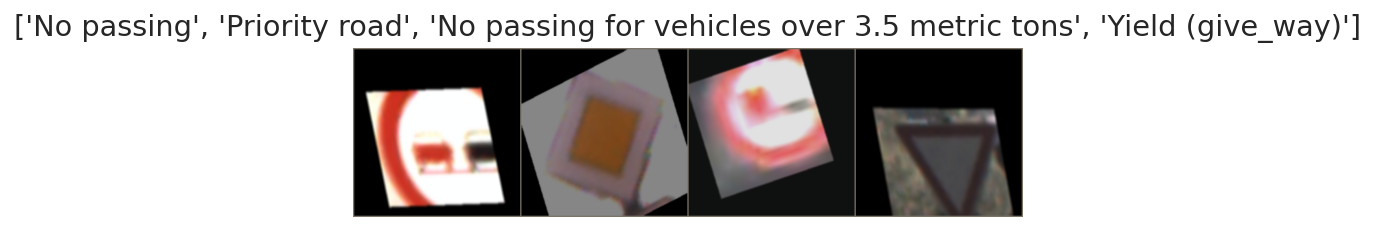

In [14]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [15]:
def create_model(net_model, n_classes):

  if(net_model=='resnet18'):
    model = models.resnet18(pretrained = True, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if (net_model == 'alexnet'):
    model = models.alexnet(pretrained = True, progress = True)
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(n_features,n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'shufflenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
    model.fc = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True, progress=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

#  if(net_model == 'NASNet-A-Mobile'):
#    #model = timm.create_model('nasnetalarge', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
#    #nasnetamobile(num_classes=1000, pretrained='imagenet')
#    model = models.nasnetmobile(pretrained = True, progress=True)


    #model = models.mobilenet_v3_small(pretrained=True, progress=True)
    #print(model.classifier) 

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [16]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [18]:
                                                                    #30
def train_model(model,net, data_loaders, dataset_sizes, device, n_epochs=10):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  PATH = 'drive/MyDrive/Modelli'
  if(net=='resnet18'):
    PATH = 'drive/MyDrive/Modelli/resnet18/resnet18.pt'

  if (net == 'alexnet'):
    PATH = 'drive/MyDrive/Modelli/alexnet/alexnet.pt'

  if(net == 'googleLeNet'):
    PATH = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt'

  if(net=='mobilenet_v2'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2.pt'

  if(net=='mobilenet_v3'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v3.pt'

  if(net == 'shufflenet_v2'):
    PATH = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.pt'

  if(net == 'efficientnet_b0'):
    PATH = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0.pt'

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      #torch.save(model.state_dict(), 'drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.bin')
      torch.save(model.state_dict(), PATH)
      
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  torch.save(model.state_dict(), PATH)
  print("Model saved")

  
  return model, history


Scelta e training del modello:

##ResNet18

In [19]:
base_model = create_model("resnet18",len(class_names))

#comando time restituisce wall time della cella

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
%%time

base_model, history = train_model(base_model, 'resnet18', data_loaders, dataset_sizes, device)

##AlexNet

In [ ]:
%%time
base_model = create_model('alexnet', len(class_names))


base_model, history = train_model(base_model, 'alexnet', data_loaders, dataset_sizes, device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.208136021657175  accuracy 0.375553926100679
Val   loss 0.7629202907649568  accuracy 0.7620504973221117

Epoch 2/10
----------
Train loss 1.387567051396071  accuracy 0.605700258233175
Val   loss 0.20829312473896816  accuracy 0.9428717163988778

Epoch 3/10
----------
Train loss 1.1775299816576472  accuracy 0.6742117512034941
Val   loss 0.16321383002432827  accuracy 0.9500127518490181

Epoch 4/10
----------
Train loss 0.6909717350560717  accuracy 0.799151975005579
Val   loss 0.029980961068045035  accuracy 0.9910737056873247

Epoch 5/10
----------
Train loss 0.582535937098535  accuracy 0.8263142793381578
Val   loss 0.022097255314745348  accuracy 0.9928589645498597

Epoch 6/10
----------
Train loss 0.5418174464570424  accuracy 0.8386839672267031
Val   loss 0.019544663650156363  accuracy 0.993369038510584

Epoch 7/10
----------


##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, 'googleLeNet', data_loaders, dataset_sizes, device)

##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, 'mobilenet_v2', data_loaders, dataset_sizes, device)

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, 'mobilenet_v3' , data_loaders, dataset_sizes, device)

##ShuffleNet_v2

In [ ]:
%%time
base_model = create_model('shufflenet_v2', len(class_names))


base_model, history = train_model(base_model, 'shufflenet_v2', data_loaders, dataset_sizes, device)

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, 'efficientnet_b0', data_loaders, dataset_sizes, device)

##Visualizzazione History

In [ ]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], 'o-', label='train loss')
  ax1.plot(history['val_loss'], '^-', label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 3.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], 'o-', label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], '^-', label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')
  fig.savefig('drive/MyDrive/Modelli/alexnet/alexnet.png')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

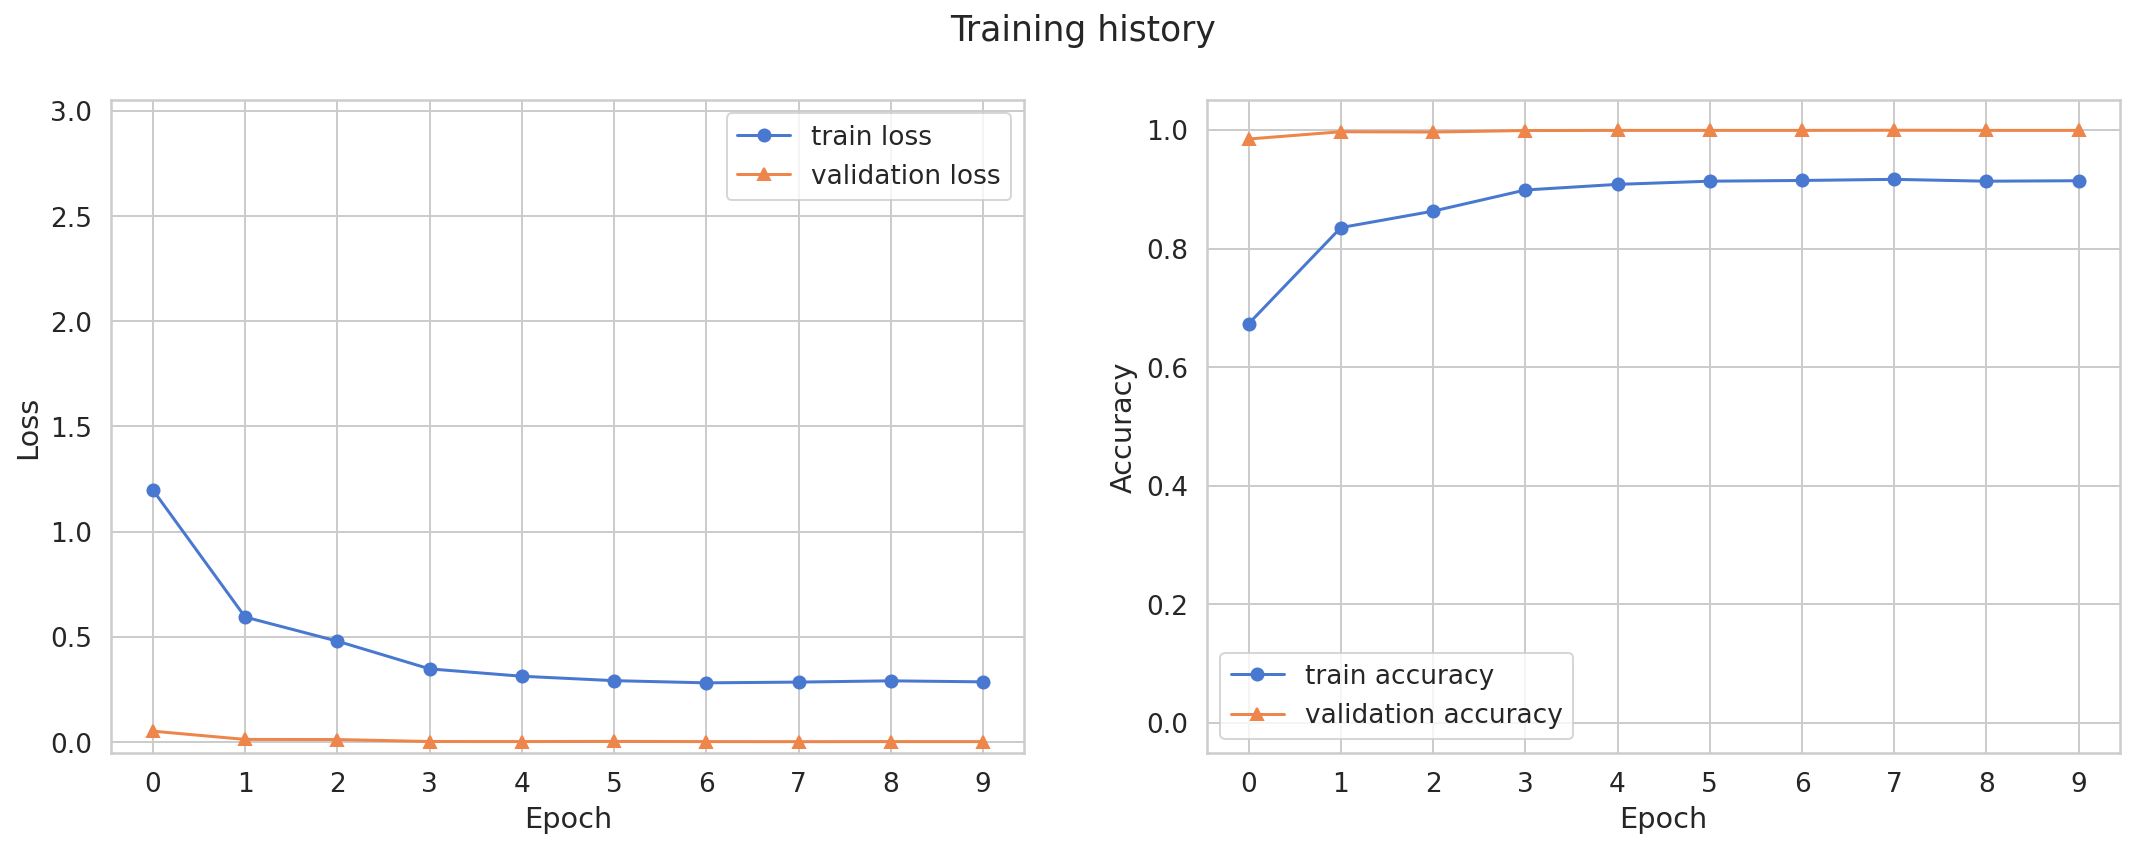

In [ ]:
plot_training_history(history)


### Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [34]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


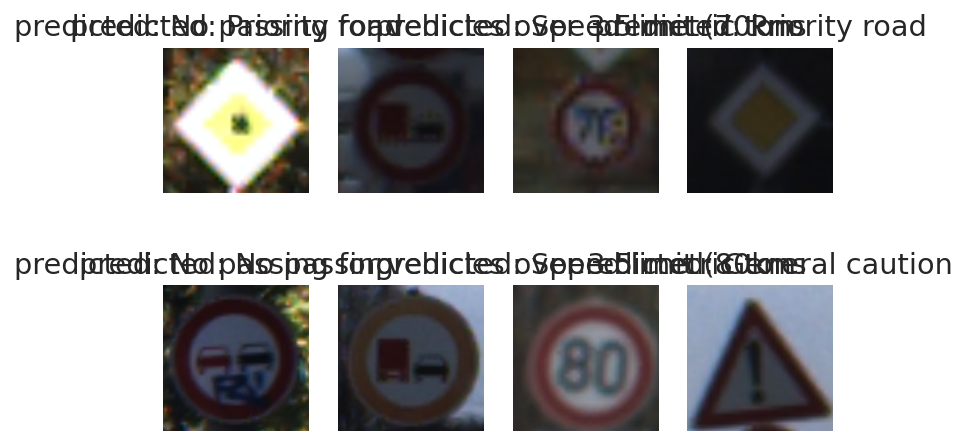

In [38]:
base_model = create_model('resnet18', 43)
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.pt',map_location=torch.device('cpu')))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt', map_location = device ))

#base_model = create_model('alexnet', 43)
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/alexnet/alexnet.pt', map_location = device))      

show_predictions(base_model, class_names, n_images=8)

In [36]:
def get_predictions(model, data_loader):
  frame_count = 0 # To count total frames.
  total_fps = 0 # To get the final frames per second.

  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      start_time = time.time() #time
      outputs = model(inputs)
      end_time = time.time()

      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)

      fps = 1 / (end_time - start_time)
  
      total_fps += fps
      
      frame_count += 1

  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  avg_fps = total_fps / frame_count
  return predictions, real_values, avg_fps

In [39]:
y_pred, y_test , FPS = get_predictions(base_model, data_loaders['test'])
print(y_pred, y_test)
print('Avg FPS:',FPS)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([36,  3, 12,  ..., 16, 35, 34]) tensor([36,  3, 12,  ..., 16, 35, 34])
Avg FPS: 150.76362991726808


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

##TEST

In [19]:
# Define path of test data
import torch.utils.data as data

test_data_path = "drive/MyDrive/GTSRB/Test"
test_transforms = T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
])

test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

# Generating labels of classes

num = range(43)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

FileNotFoundError: ignored

In [ ]:
# Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

df = pd.read_csv("drive/MyDrive/GTSRB/Test.csv")
numExamples = len(df)
labels_list = list(df.ClassId)
# Load the saved model


model = create_model('resnet18', 43)
model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt'))
# Perform classification

y_pred_list = []
corr_classified = 0

with torch.no_grad():
    model.eval()

    i = 0

    for image, _ in test_loader:
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        if labels_list[i] == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

# Print classification report

print(classification_report(labels_list, y_pred_list))

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
  

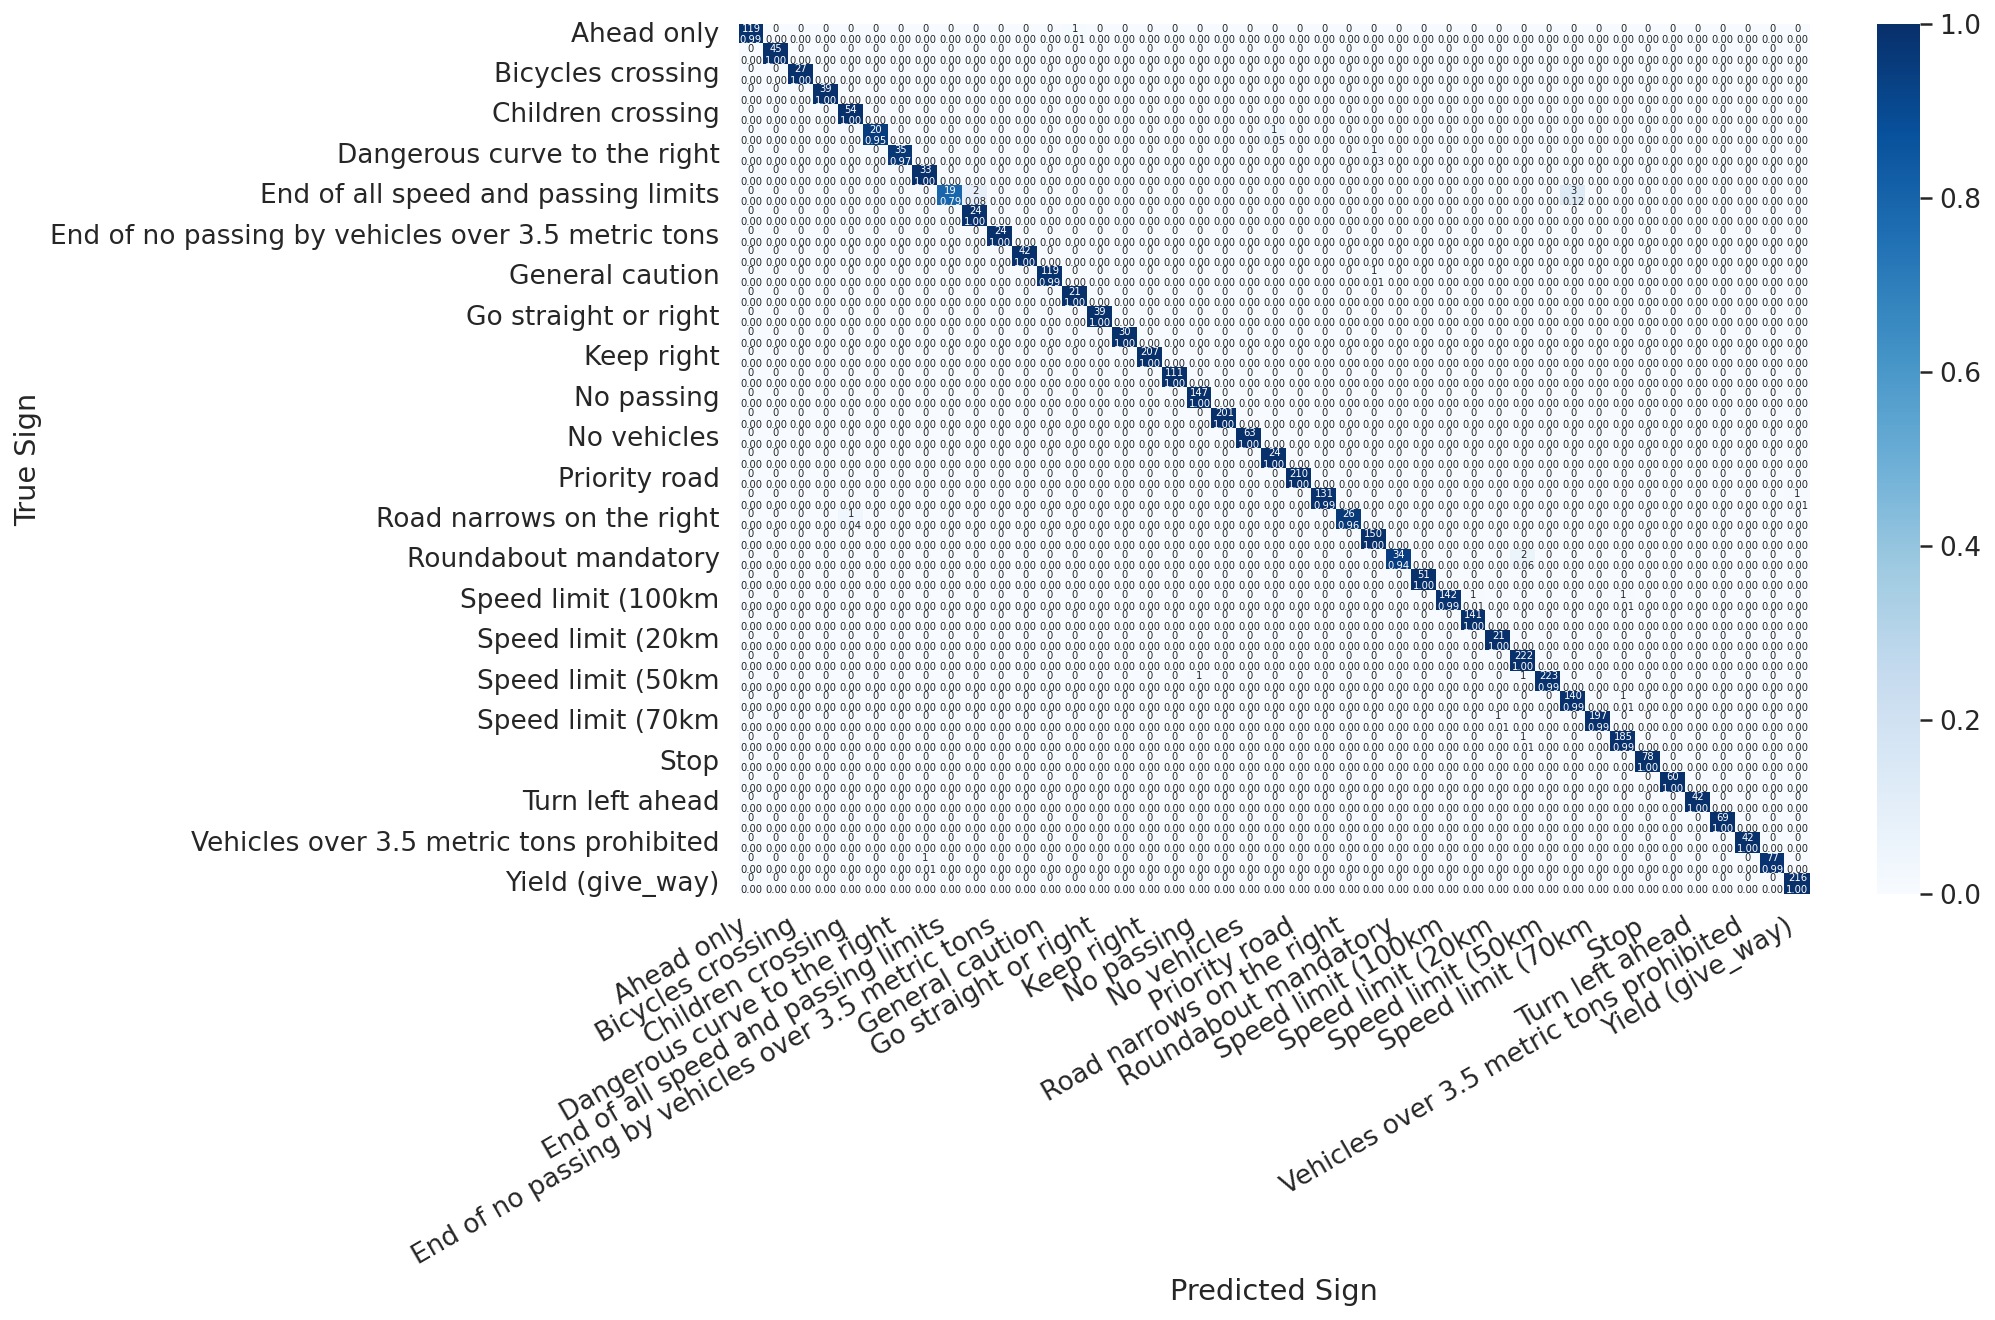

In [ ]:
cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)

## Classificazione immagine non vista


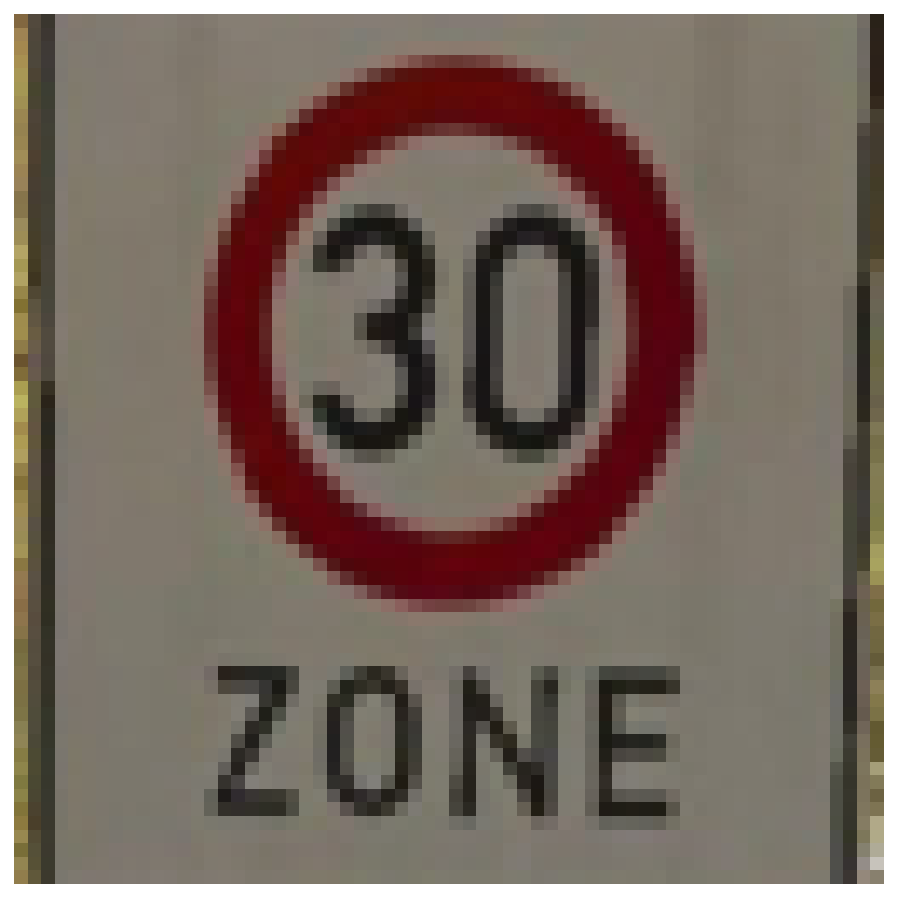

In [ ]:
#!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
#!gdown https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSrE6qyU5oAorfk_ABkjTcqtLXrwqUI3pxfhK5TeOP0cJqGa9mECMhx39vXxqjKtxhcVh0&usqp=CAU
#show_image('stop-sign.jpg')


#show_image('/content/images?q=tbn:ANd9GcSrE6qyU5oAorfk_ABkjTcqtLXrwqUI3pxfhK5TeOP0cJqGa9mECMhx39vXxqjKtxhcVh0')

show_image('drive/MyDrive/inference/IMG_20220710_195852_099.jpg')

Test Trasformazioni

In [ ]:
import PIL.Image
import matplotlib.pyplot as plt
#show_image('stop-sign.jpg')

#tran = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75), shear=(-10, 10))
tran = T.Compose([ T.RandomAffine(degrees=(-30, 30), translate=(0.1,0.3), scale=(0.6,1), shear=(-20, 20)),
T.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0)])


def imshowTra(img, transform):
    """
    :param img: Path dell'immagine
    :param transform: data augmentation da applicare"""
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'immagine originale {img.size}')
    ax[0].imshow(img)
    img = transform(img)
    ax[1].set_title(f'immagine trasformata {img.size}')
    ax[1].imshow(img)
for i in range(5):
  imshowTra('/content/00000_00000_00025.png',tran)

FileNotFoundError: ignored

Predizione con confidenza rispetto a tutte le classi possibili

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(base_model, 'drive/MyDrive/inference/IMG_20220710_195852_099.jpg')
#pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([3.6159442e-09, 8.8507629e-10, 1.3597929e-07, 3.6252963e-08,
       5.1721671e-09, 5.6124176e-09, 3.1667324e-10, 3.0109228e-11,
       6.3515230e-08, 1.6315353e-07, 2.3573768e-10, 5.2146127e-09,
       5.2177760e-09, 2.0225996e-10, 6.1580274e-10, 3.0943856e-09,
       1.1830834e-08, 3.1671870e-09, 4.5981928e-06, 4.5171338e-09,
       7.3993015e-06, 7.3458439e-10, 2.1066338e-08, 1.2116593e-08,
       8.6848229e-10, 7.2847763e-09, 1.5603027e-09, 2.9244518e-09,
       1.9131693e-07, 6.2844435e-10, 1.4937338e-05, 9.9994004e-01,
       5.5871128e-06, 4.4515257e-08, 5.0938797e-07, 2.4096667e-05,
       1.0439056e-09, 1.2092091e-09, 5.4832927e-10, 1.2124076e-09,
       1.8062265e-06, 3.2801364e-10, 2.8575002e-07], dtype=float32)

Plot confidenza

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

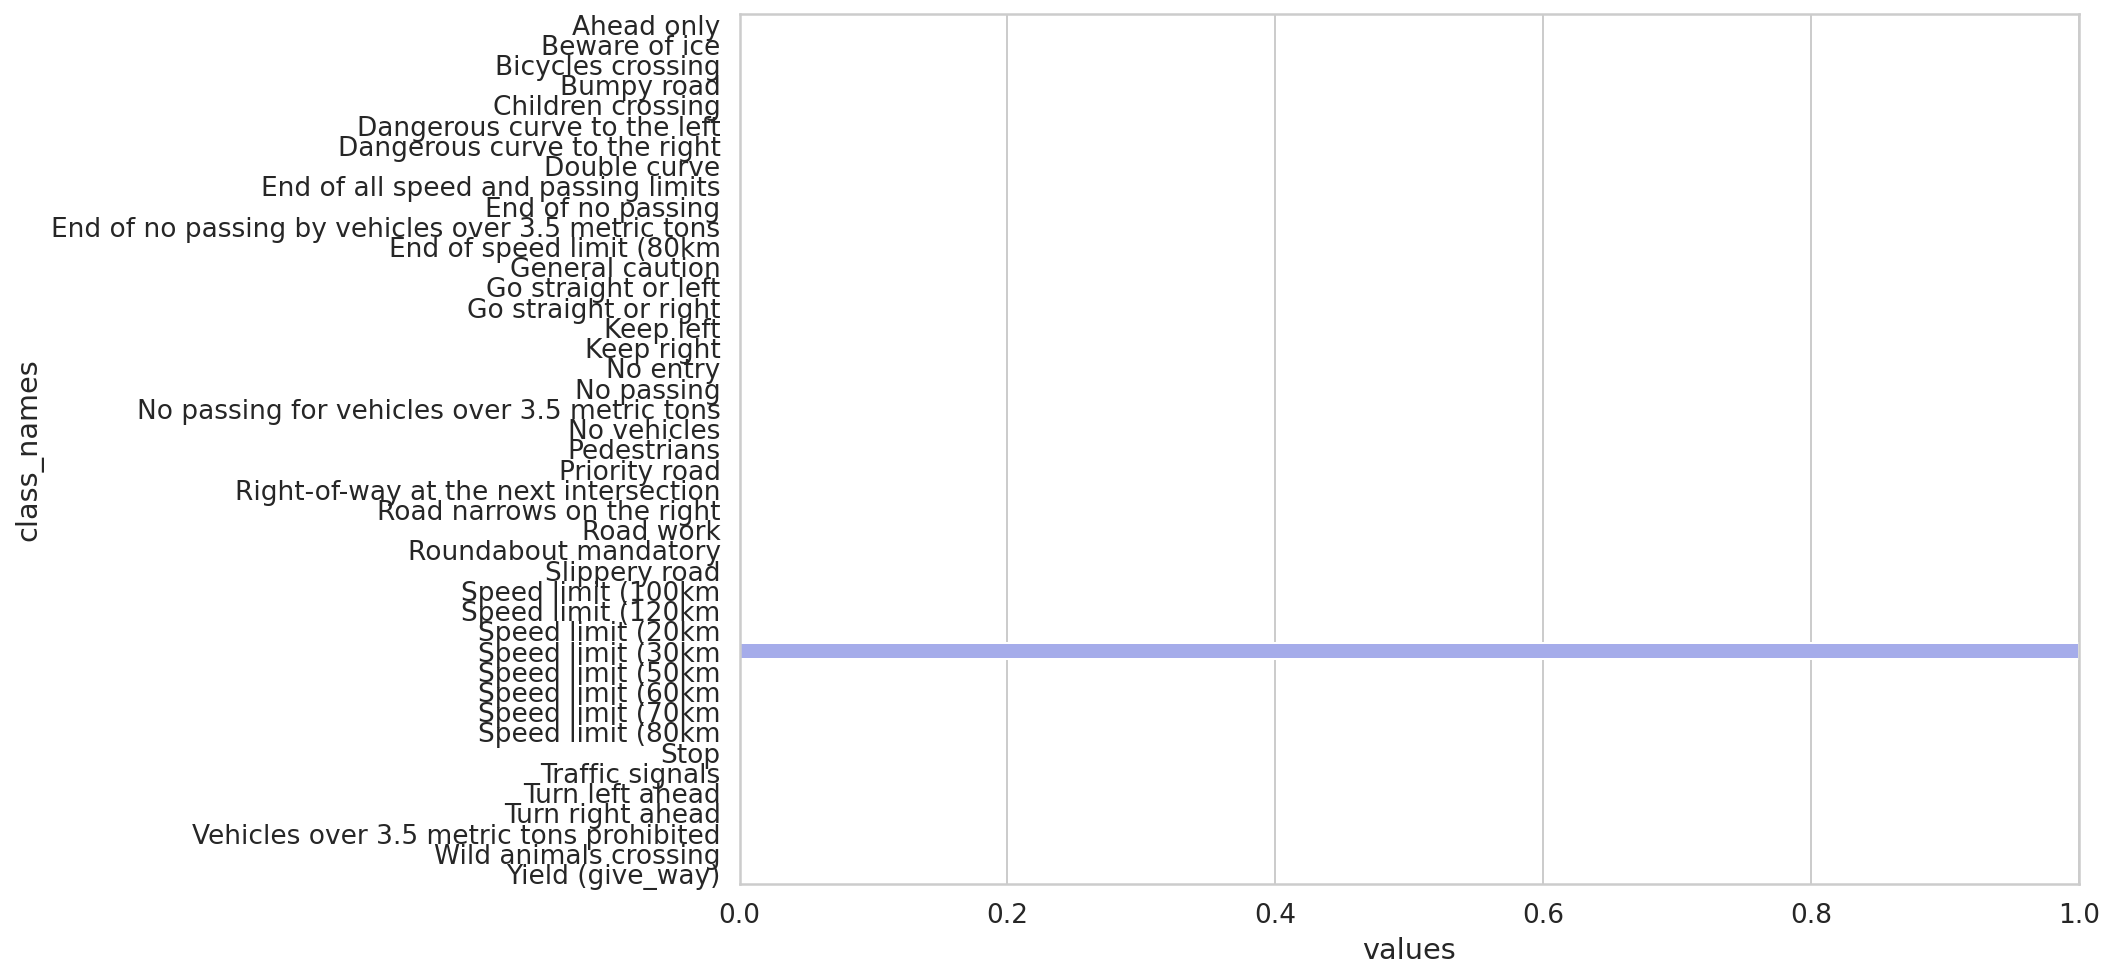

In [ ]:
show_prediction_confidence(pred, class_names)

##FPS

In [39]:
import numpy as np
import cv2
import torch
import os
import time
import argparse
import pathlib
import PIL
from PIL import Image
#import custom_utils


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GTSRB/Final_Test
!rm -rf GT-final_test.csv
!rm -rf GTSRB/Readme-Images-Final-test.txt
!rm -rf GTSRB/Readme-Images.txt

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -qq GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_GT.zip
#show_image('GTSRB/Final_Test/Images/00000.ppm')

base_model = create_model("resnet18",len(class_names))

base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt', map_location = device))     
base_model.eval()

# DataFrame for ground truth.
gt_df = pd.read_csv(
    'GT-final_test.csv', 
    delimiter=';'
)
gt_df = gt_df.set_index('Filename', drop=True)
# Initialize model, switch to eval model, load trained weights.


counter = 0
# Run for all the test images.
all_images = 'GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/*.ppm'
correct_count = 0
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second. 
transform = T.Compose([T.Resize(size=256),
                       T.CenterCrop(size=224),
                       T.ToTensor(),
                       T.Normalize(mean_nums, std_nums)])

for i, image_path in enumerate(all_images):
    # Read the image.
    image = cv2.imread(image_path)
    
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape
    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)

    
    # Forward pass through model.
    start_time = time.time()
    outputs = model(image_tensor.to(device))
    end_time = time.time()
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    gt_idx = gt_df.loc[image_name].ClassId
    # Check whether correct prediction or not.
    if gt_idx == class_idx:
        correct_count += 1
    '''
    # Generate class activation mapping for the top1 prediction.
    CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
    # File name to save the resulting CAM image with.
    save_name = f"{image_path.split('/')[-1].split('.')[0]}"
    # Show and save the results.
    #result = apply_color_map(CAMs, width, height, orig_image)
    #visualize_and_save_map(result, orig_image, gt_idx, class_idx, save_name)
    counter += 1
    print(f"Image: {counter}")
    # Get the current fps.
    '''
    fps = 1 / (end_time - start_time)
    # Add `fps` to `total_fps`.
    total_fps += fps
    # Increment frame count.
    frame_count += 1
print(f"Total number of test images: {len(all_images)}")
print(f"Total correct predictions: {correct_count}")
print(f"Accuracy: {correct_count/len(all_images)*100:.3f}")
# Close all frames and video windows.
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


--2022-07-11 20:15:45--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  14.1MB/s    in 7.8s    

2022-07-11 20:15:54 (10.9 MB/s) - ‘GTSRB_Final_Test_Images.zip’ saved [88978620/88978620]

--2022-07-11 20:15:54--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   220KB/s    in 0.4s    

AttributeError: ignored

##FPS 2

In [32]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rf GTSRB/Final_Test
!rm -rf GTSRB/Readme-Images-Final-test.txt
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_Images.zip
!unzip -qq GTSRB_Final_Test_Images.zip
#!mv GTSRB/Final_Test/ data/

!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GT-final_test.csv
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_GT.zip
!unzip -qq GTSRB_Final_Test_GT.zip
#!mv GT-final_test.csv data/Final_Test/Images/

# Define transformations

test_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
    ])

# Define path of test data

test_data_path = 'GTSRB/Final_Test'
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

# Define hyperparameters

numClasses = 43

# Generating labels of classes

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

    # Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

df = pd.read_csv('GT-final_test.csv')
numExamples = len(df)
#labels_list = list(df.ClassId)
df = df.iloc[1: , :] #drop prima riga
labels_list = df.iloc[:,-1:] # prendi ultima colonna


base_model = create_model("resnet18",len(class_names))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt', map_location = device))     

#model = base_model.toDevice()
model=base_model


rm: cannot remove 'GTSRB_Final_Test_Images.zip': No such file or directory
--2022-07-11 21:18:17--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-11 21:18:18 ERROR 404: Not Found.

unzip:  cannot find or open GTSRB_Final_Test_Images.zip, GTSRB_Final_Test_Images.zip.zip or GTSRB_Final_Test_Images.zip.ZIP.
rm: cannot remove 'GTSRB_Final_Test_GT.zip': No such file or directory
--2022-07-11 21:18:19--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-11 21:18:19 ERROR 404: Not Found.

unzip:  cannot find or open GTSRB_Final_Test_GT.zip

FileNotFoundError: ignored

In [30]:
# Perform classification

y_pred_list = []
corr_classified = 0

with torch.no_grad():
    model.eval()

    i = 0

    for image, _ in test_loader:
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        if labels_list[i] == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

IndexError: ignored

##Final Test